In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import colorcet as cc
import pickle
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy

from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from esda.moran import Moran
from libpysal.weights import KNN

In [2]:
palette = sns.color_palette(cc.glasbey, n_colors=15)

# Load data

In [3]:
DATA_PATH = Path("../data")  # specify data directory

In [4]:
coordinates = pd.read_parquet(DATA_PATH / 'coordinates.parquet')
supercogs   = pd.read_parquet(DATA_PATH / 'supercogs.parquet')

### Intermediate data

In [5]:
nums_hq  = pd.read_csv(DATA_PATH / 'intermediate' / 'nums_db_hq_clusters.csv', index_col=0)
nums_all = pd.read_csv(DATA_PATH / 'intermediate' / 'nums_db_clusters.csv', index_col=0)
X_cath_pacmap_trans_normed   = pd.read_csv(DATA_PATH / 'intermediate' / 'X_cath_pacmap_trans_normed.csv', index_col=0)
X_cath_pacmap_trans_unnormed = pd.read_csv(DATA_PATH / 'intermediate' / 'X_cath_pacmap_trans_unnormed.csv', index_col=0)
with open(DATA_PATH / 'intermediate' / 'hetero_clusters.pickle', 'rb') as handle:
    hetero_clust = pickle.load(handle)

# Preprocess data

In [6]:
coordinates = coordinates.join(nums_all.sum(axis=1).to_frame()).rename(columns={0: 'number_of_elements'})
coordinates = coordinates.join(nums_hq.sum(axis=1).to_frame()).rename(columns={0: 'number_of_elements_HQ'})

In [7]:
coordinates = coordinates.join(supercogs)

In [8]:
# All structures in MIP and hclust30 are treated here as of high quality
coordinates['afdb_pLDDT'] = coordinates['afdb_pLDDT'].fillna(100)

#
---
# Plots
---

## Parameters to change

In [9]:
# type_ = 'unnormed'   # consider unnormalized Geometricus vectors
type_ = 'normed'   # consider normalized Geometricus vectors

In [10]:
ONLY_HQ_AFDB = True  # consider only high-quality AFDB models (set False to reproduce Fig. 1B and 3B)  

## Do not change the cels below

In [11]:
if type_ == 'normed':
    cnames = ['x', 'y']
else:
    cnames = ['x_un', 'y_un']

In [12]:
if ONLY_HQ_AFDB:
    # note: representatives may be of low quality 
    # but cluster contain at least one structure of high quality
    input = coordinates[coordinates.index.isin(nums_hq.index)]
    # alternatively, we may consider also a threshold put on pLDDT for all representatives
    # input = coordinates.loc[(coordinates.afdb_pLDDT > 70)]
    numbers_col = 'number_of_elements_HQ'
    input = input.join(nums_hq)
else:
    input = coordinates.copy()
    input = input.join(nums_all)
    numbers_col = 'number_of_elements'

In [13]:
x_min, x_max = input[cnames[0]].min() * 1.1, input[cnames[0]].max() * 1.2
y_min, y_max = input[cnames[1]].min() * 1.1, input[cnames[1]].max() * 1.2

In [14]:
bins = [np.arange(x_min, x_max, (x_max - x_min) / 300),
       np.arange(y_min, y_max, (y_max - y_min) / 300)]

# Number of structures

In [15]:
is_cat = ['is_clust', 'is_repr']

In [16]:
heatmaps_cat_allstruct = input.loc[input.index.repeat(input[numbers_col])]
heatmaps_cat_allstruct, xedges, yedges = np.histogram2d(heatmaps_cat_allstruct[cnames[0]], 
                                                        heatmaps_cat_allstruct[cnames[1]], bins=bins)

In [17]:
heatmaps_cat = {}
heatmaps_cat['is_clust'], xedges, yedges = np.histogram2d(input[input['is_cluster'] == True][cnames[0]], 
                                                     input[input['is_cluster'] == True][cnames[1]], bins=bins)
heatmaps_cat['is_repr'], xedges, yedges = np.histogram2d(input[cnames[0]], input[cnames[1]], bins=bins)

In [18]:
input['x_bin'] = np.digitize(input[cnames[0]], xedges) - 1  # bins start from 0
input['y_bin'] = np.digitize(input[cnames[1]], yedges) - 1  # bins start from 0

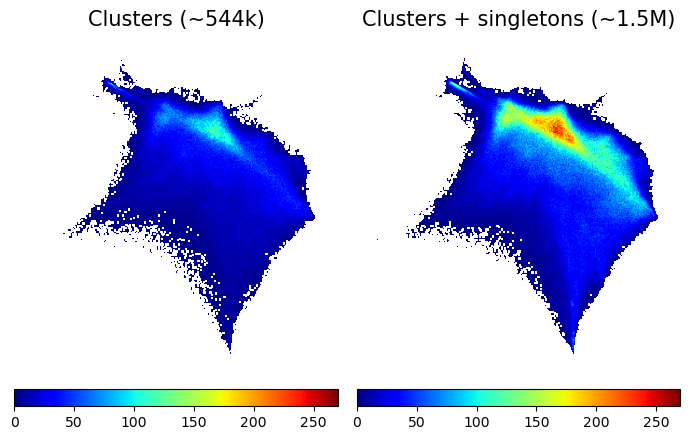

In [19]:
fig, ax = plt.subplots(1, len(is_cat), figsize=(7, 4.5))
for i, t in enumerate(is_cat):
    heatmap = heatmaps_cat[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t == 'is_clust':
        title = 'Clusters (~544k)'
    else:
        title = 'Clusters + singletons (~1.5M)'
    if type_ == 'normed':
        vmax = 270
    else:
        vmax = 200
    im = ax[i].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])

    ax[i].set_title(title, fontsize=15)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Protein length

In [20]:
agg_len = input.groupby(['x_bin', 'y_bin'])['length'].agg(['median', 'mean', 'std',
                                                           scipy.stats.median_abs_deviation]).reset_index()

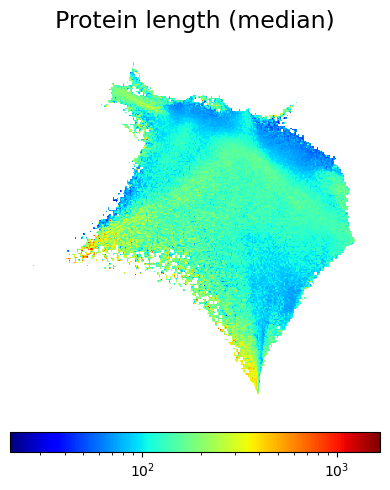

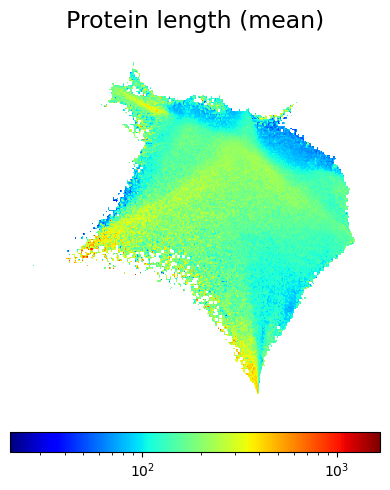

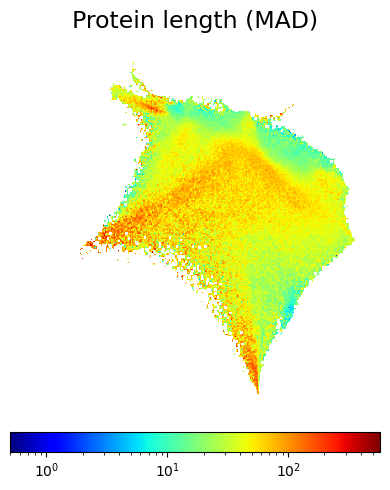

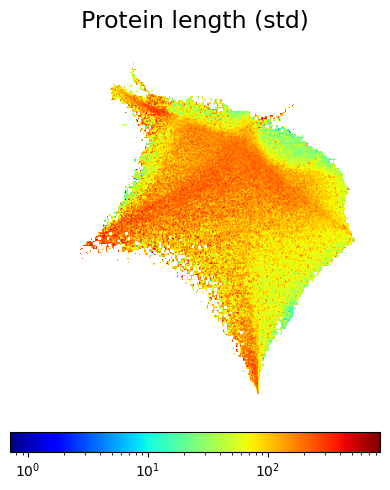

In [21]:
for feat in ['median', 'mean', 'median_abs_deviation', 'std']:
# for feat in ['median', 'median_abs_deviation']:
    heatmap_len = np.zeros((len(bins[0])-1, len(bins[1])-1))
    # Use np.add.at to aggregate feature values into the 3D array
    np.add.at(heatmap_len, (agg_len['x_bin'].values, agg_len['y_bin'].values), agg_len[feat].values)
    heatmap_len = np.where(heatmap_len==0, np.nan, heatmap_len)
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    im = ax.imshow(heatmap_len.T, extent=extent, origin='lower', 
                      norm=colors.LogNorm(),
                      cmap=cm.jet, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax)
    if feat == 'median_abs_deviation':
        feat = 'MAD'
    ax.set_title(f'Protein length ({feat})', fontsize=17)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Database type

In [22]:
db_types = ['afdb-clusters-dark', 'afdb-clusters-light', 'hclust30-clusters', 'mip-singletons', 'mip-clusters']
db_labels = {
    'afdb-clusters-dark': 'AFDB dark clusters',
    'afdb-clusters-light': 'AFDB light clusters', 
    'hclust30-clusters': 'ESMAtlas clusters',
    'mip-singletons': 'MIP singletons',
    'mip-clusters': 'MIP clusters'
}

In [23]:
heatmaps_db_allstruct, xedges, yedges = {}, {}, {}
for t in db_types:
    tmp = input.loc[input.index.repeat(input[t])]
    heatmaps_db_allstruct[t], xedges, yedges = np.histogram2d(tmp[cnames[0]], tmp[cnames[1]], bins=bins)

## All structures

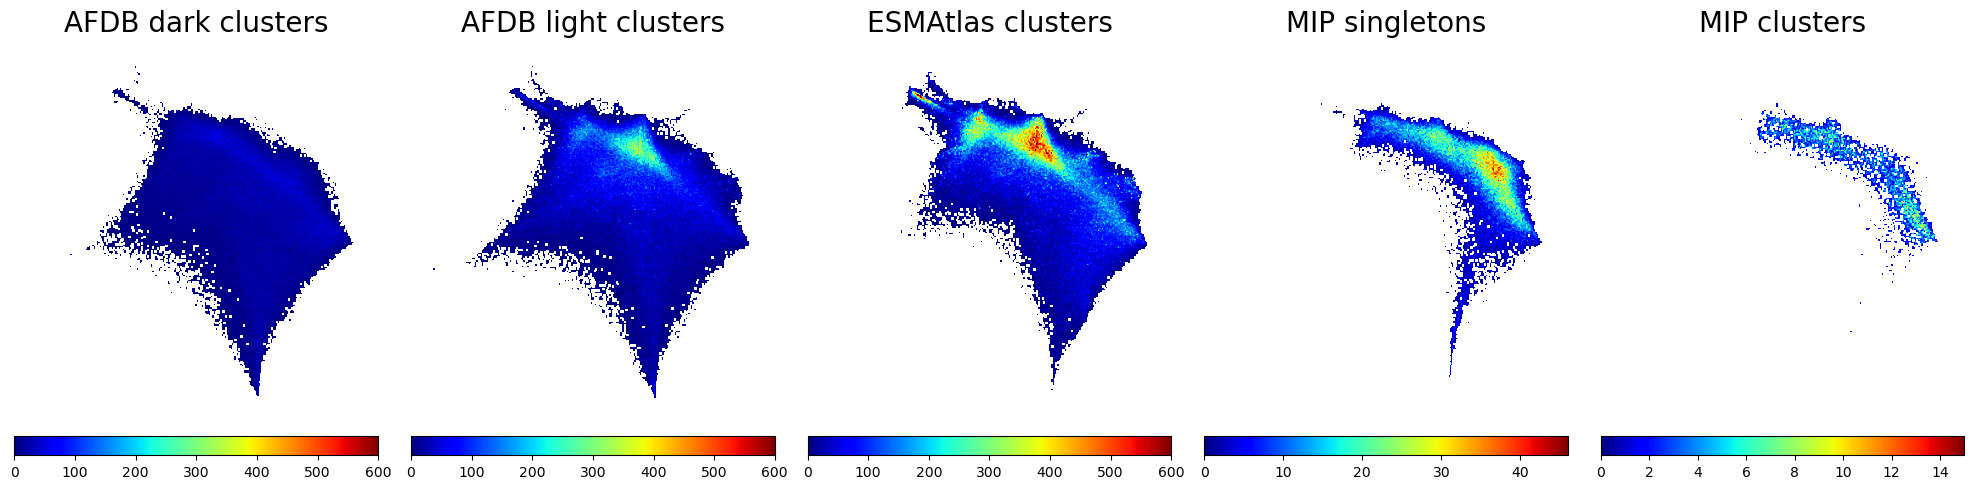

In [24]:
db_types1 = ['afdb-clusters-dark', 'afdb-clusters-light', 'hclust30-clusters']
db_types2 = ['mip-singletons', 'mip-clusters']
fig, ax = plt.subplots(1, len(db_types), figsize=(20, 5))
for i, t in enumerate(heatmaps_db_allstruct):
    heatmap = heatmaps_db_allstruct[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in db_types1:
        if type_ == 'unnormed':
            vmax=300
        else:
            vmax=600
    else:
        vmax = heatmaps_db_allstruct[t].max()
    im = ax[i].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    ax[i].set_title(db_labels[t], fontsize=20)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Repr. structures

In [25]:
heatmaps_db, xedges, yedges = {}, {}, {}
for t in db_types:
    heatmaps_db[t], xedges, yedges = np.histogram2d(input[input['origin'] == db_labels[t]][cnames[0]], 
                                                    input[input['origin'] == db_labels[t]][cnames[1]], bins=bins)

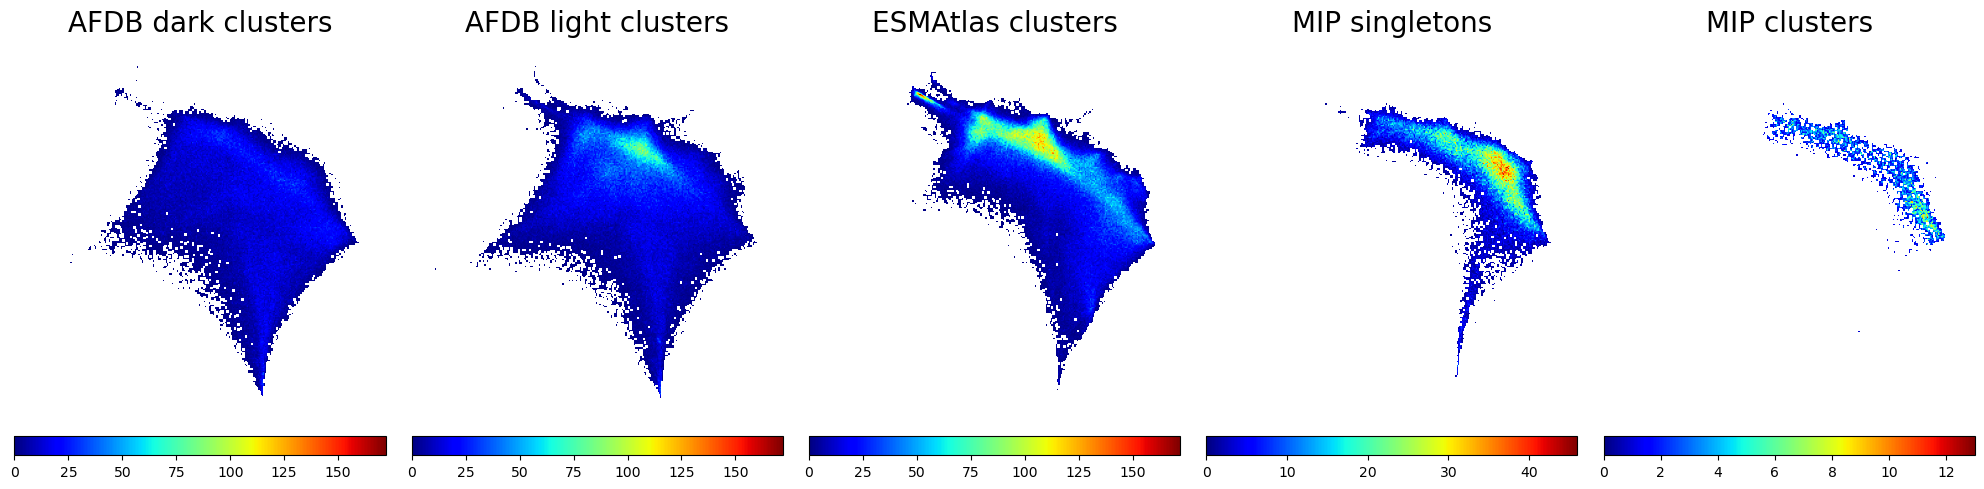

In [26]:
db_types1 = ['afdb-clusters-dark', 'afdb-clusters-light', 'hclust30-clusters']
db_types2 = ['mip-singletons', 'mip-clusters']
fig, ax = plt.subplots(1, len(db_types), figsize=(20, 5))
for i, t in enumerate(db_types):
    heatmap = heatmaps_db[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in db_types1:
        vmax = max([heatmaps_db[t].max() for t in db_types1])
    else:
        vmax = heatmaps_db[t].max()
    im = ax[i].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    ax[i].set_title(db_labels[t], fontsize=20)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## All structures

/tmp/ipykernel_4017428/3245732230.py:13: RuntimeWarning: invalid value encountered in divide
  im = ax[i].imshow((heatmap / heatmaps_cat_allstruct).T, extent=extent, origin='lower',


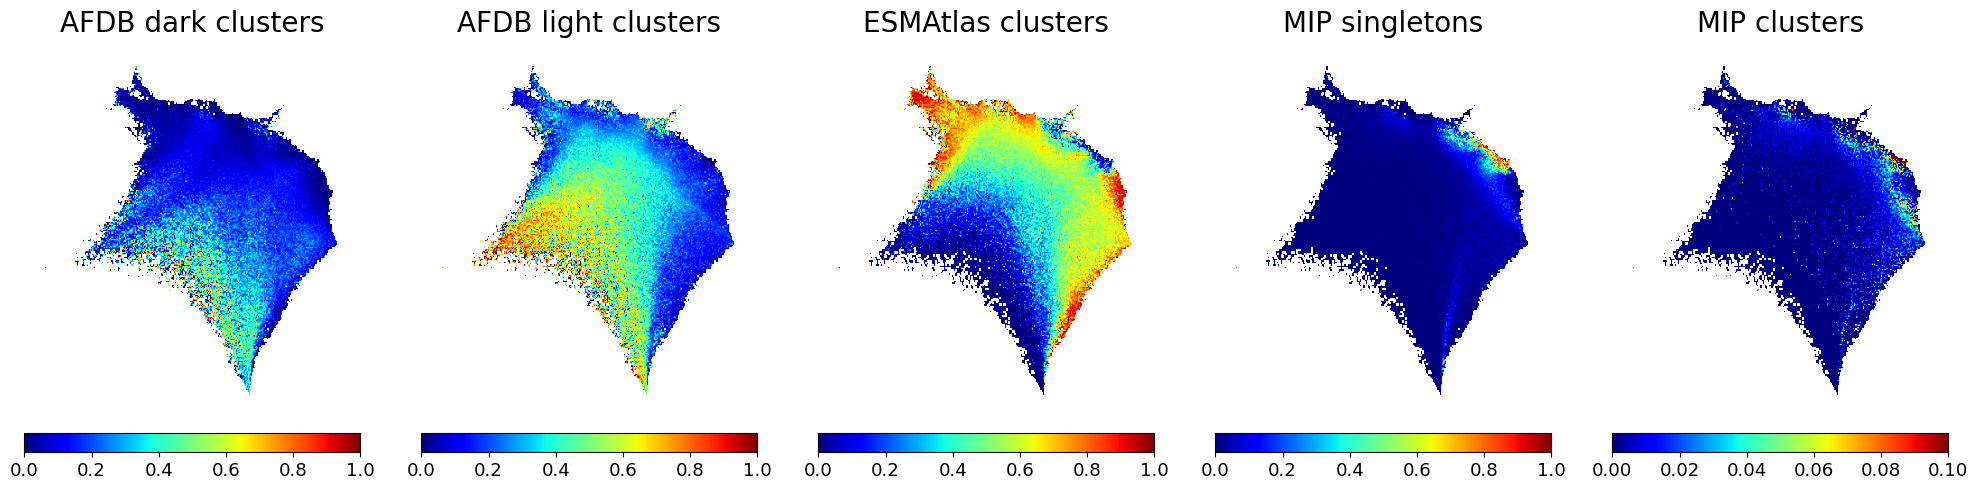

In [27]:
db_types1 = ['afdb-clusters-dark', 'afdb-clusters-light', 'hclust30-clusters', 'mip-singletons']
db_types2 = ['mip-clusters']
fig, ax = plt.subplots(1, len(db_types), figsize=(20, 5))
for i, t in enumerate(db_types):
    heatmap = heatmaps_db_allstruct[t]
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in db_types1:
        vmax = 1
    else:
        vmax = 0.1
    im = ax[i].imshow((heatmap / heatmaps_cat_allstruct).T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    cbar = plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    cbar.ax.tick_params(labelsize=13)
    ax[i].set_title(db_labels[t], fontsize=20)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Repr. structures

/tmp/ipykernel_4017428/4166295285.py:13: RuntimeWarning: invalid value encountered in divide
  im = ax[i].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower',


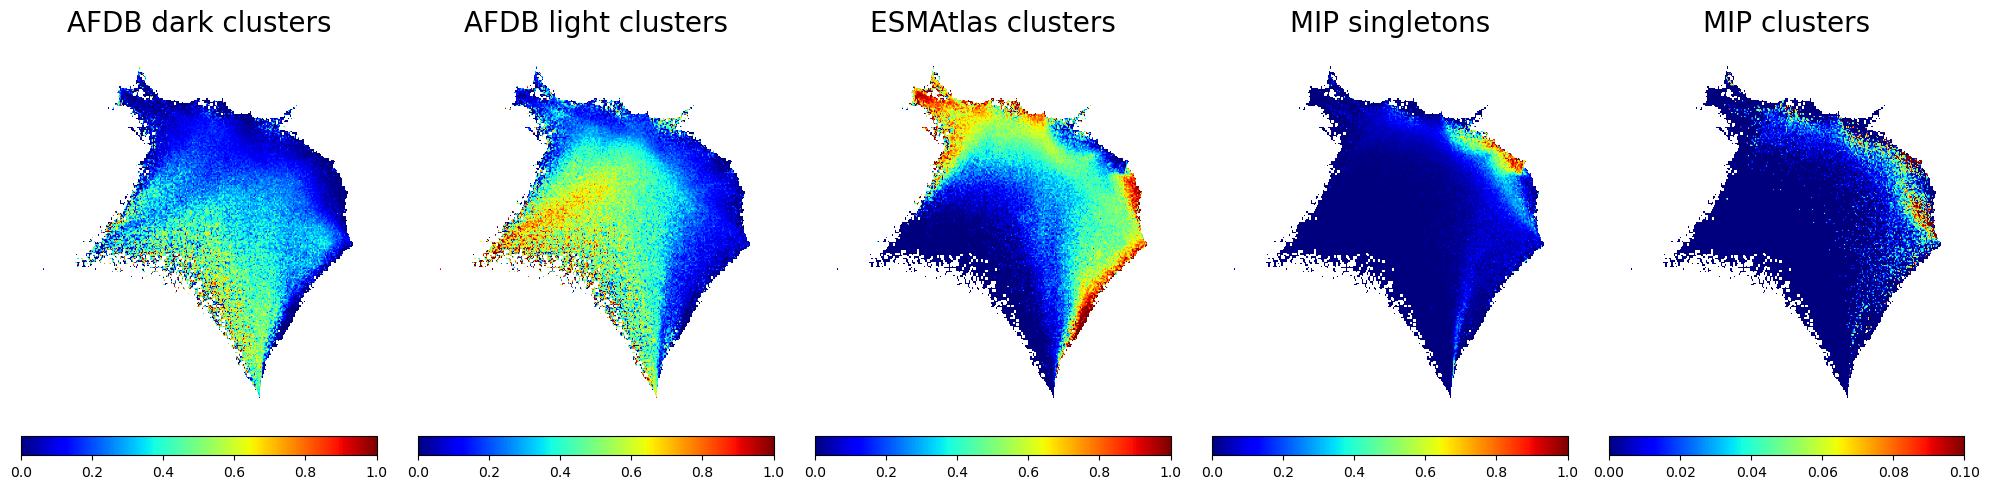

In [28]:
db_types1 = ['afdb-clusters-dark', 'afdb-clusters-light', 'hclust30-clusters', 'mip-singletons']
db_types2 = ['mip-clusters']
fig, ax = plt.subplots(1, len(db_types), figsize=(20, 5))
for i, t in enumerate(db_types):
    heatmap = heatmaps_db[t]
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in db_types1:
        vmax = 1
    else:
        vmax = 0.1
    im = ax[i].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    ax[i].set_title(db_labels[t], fontsize=20)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# SuperCOGs

In [29]:
super_types = ['s1', 's2', 's3', 'R', 's12', 's23', 's13', 'unannotated']
super_types1 = ['s1', 's2', 's3', 'R', 's12', 's23', 's13']
super_types2 = ['unannotated']

In [30]:
supercog_labels = {
    's1': 'superCOG 1',
    's2': 'superCOG 2',
    's3': 'superCOG 3',
    's12': 'superCOG 1+2',
    's13': 'superCOG 1+3',
    's23': 'superCOG 2+3',
    'unannotated': 'unannotated',
    'R': 'general function',
}

In [31]:
heatmaps_s10, xedges, yedges = {}, {}, {}
for t in super_types:
    heatmaps_s10[t], xedges, yedges = np.histogram2d(input[input['superCOG_v10'] == supercog_labels[t]][cnames[0]], 
                                                     input[input['superCOG_v10'] == supercog_labels[t]][cnames[1]], 
                                                     bins=bins)

In [32]:
heatmaps_s11, xedges, yedges = {}, {}, {}
for t in super_types:
    heatmaps_s11[t], xedges, yedges = np.histogram2d(input[input['superCOG_v11'] == supercog_labels[t]][cnames[0]], 
                                                     input[input['superCOG_v11'] == supercog_labels[t]][cnames[1]], 
                                                     bins=bins)

## Moran's I coefficients

In [33]:
# Create midpoints for x and y coordinates  
x_midpoints = (xedges[:-1] + xedges[1:]) / 2  
y_midpoints = (yedges[:-1] + yedges[1:]) / 2  
# Create all possible (x, y) coordinate pairs  
x_mesh, y_mesh = np.meshgrid(x_midpoints, y_midpoints, indexing='ij')  
coords_flat_x = x_mesh.flatten()  
coords_flat_y = y_mesh.flatten()  
# Create the initial DataFrame with coordinates  
coords_v10 = pd.DataFrame({'x': coords_flat_x, 'y': coords_flat_y})  
coords_v11 = pd.DataFrame({'x': coords_flat_x, 'y': coords_flat_y})  
# Add one column per super_type from heatmaps
for t in super_types:  
    coords_v10[t] = heatmaps_s10[t].flatten()  
    coords_v11[t] = heatmaps_s11[t].flatten()  
# Consider only coordinates for valid points
sums = coords_v10[super_types].sum(axis=1)
sums = sums[sums!=0]
coords_v10 = coords_v10.loc[sums.index]
coords_v11 = coords_v11.loc[sums.index]
# Normalize values
coords_v10[super_types] = coords_v10[super_types].div(sums, axis=0)
coords_v11[super_types] = coords_v11[super_types].div(sums, axis=0)

In [34]:
w = KNN.from_array(coords_v10[['x', 'y']], k=10)  # Adjust k as needed
moran_v10 = {'I': {}, 'p-value': {}}
for t in super_types:
    moran = Moran(coords_v10[t], w)
    print(f"{t}: Moran's I: {moran.I:.3f}, p-value: {moran.p_norm}")
    moran_v10['I'][t] = moran.I
    moran_v10['p-value'][t] = moran.p_norm

s1: Moran's I: 0.151, p-value: 0.0
s2: Moran's I: 0.160, p-value: 0.0
s3: Moran's I: 0.057, p-value: 4.832432352544091e-107
R: Moran's I: 0.128, p-value: 0.0
s12: Moran's I: 0.351, p-value: 0.0
s23: Moran's I: 0.063, p-value: 8.446181081346046e-128
s13: Moran's I: 0.157, p-value: 0.0
unannotated: Moran's I: 0.134, p-value: 0.0


In [35]:
w = KNN.from_array(coords_v10[['x', 'y']], k=10)  # Adjust k as needed
moran_v11 = {'I': {}, 'p-value': {}}
for t in heatmaps_s10.keys():
    moran = Moran(coords_v11[t], w)
    print(f"{t}: Moran's I: {moran.I:.3f}, p-value: {moran.p_norm}")
    moran_v11['I'][t] = moran.I
    moran_v11['p-value'][t] = moran.p_norm

s1: Moran's I: 0.147, p-value: 0.0
s2: Moran's I: 0.129, p-value: 0.0
s3: Moran's I: -0.002, p-value: 0.4636700918446214
R: Moran's I: 0.048, p-value: 5.016611834217202e-76
s12: Moran's I: 0.143, p-value: 0.0
s23: Moran's I: 0.014, p-value: 7.522518613733423e-08
s13: Moran's I: 0.084, p-value: 1.0186072527937152e-227
unannotated: Moran's I: -0.000, p-value: 0.9609179371633503


## Number of structures

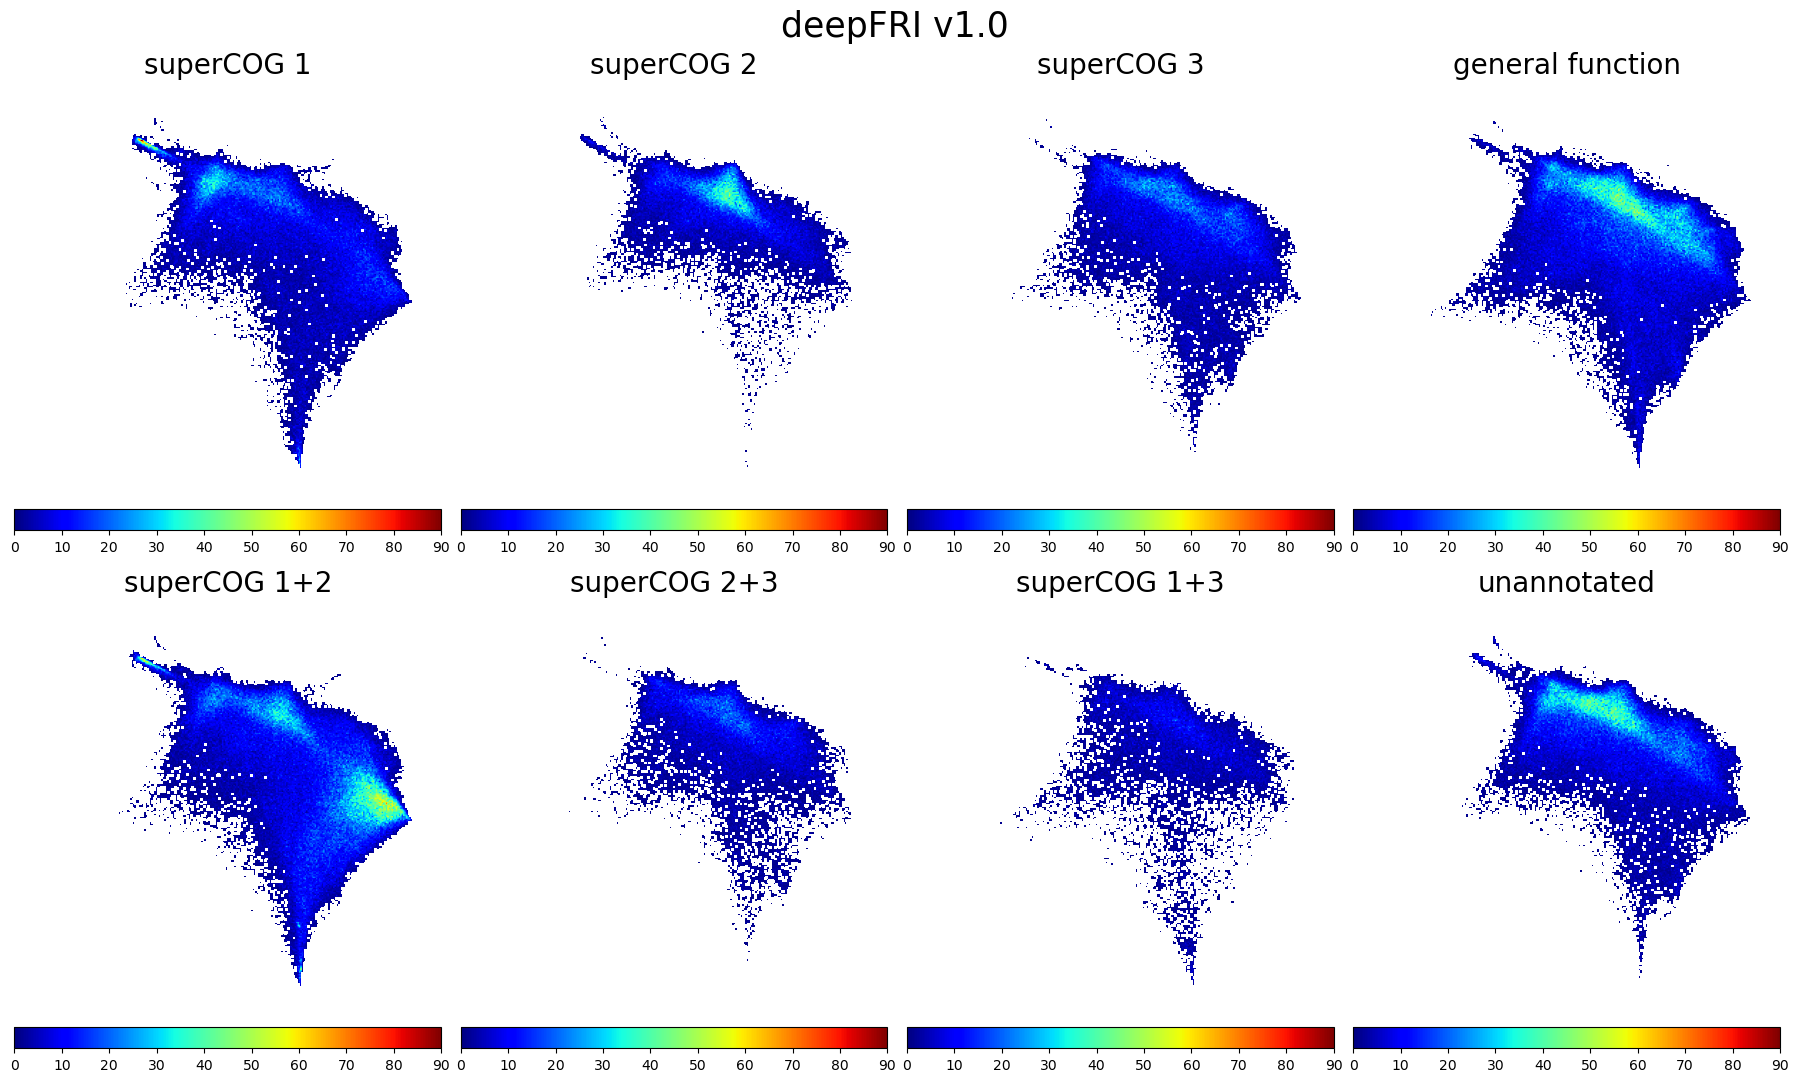

In [36]:
fig, ax = plt.subplots(2, len(super_types)//2, figsize=(18, 11))
for iter, t in enumerate(super_types):
    i = iter // (len(super_types)//2)
    j = iter % (len(super_types)//2)
    heatmap = heatmaps_s10[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i, j])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    vmax = max([heatmaps_s10[t].max() for t in super_types])
    im = ax[i, j].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i, j])
    ax[i, j].set_title(supercog_labels[t], fontsize=20)
    ax[i, j].set_xlim([x_min, x_max])
    ax[i, j].set_ylim([y_min, y_max])
    ax[i, j].axis('off')
plt.suptitle('deepFRI v1.0', fontsize=25)
plt.tight_layout()
plt.show()

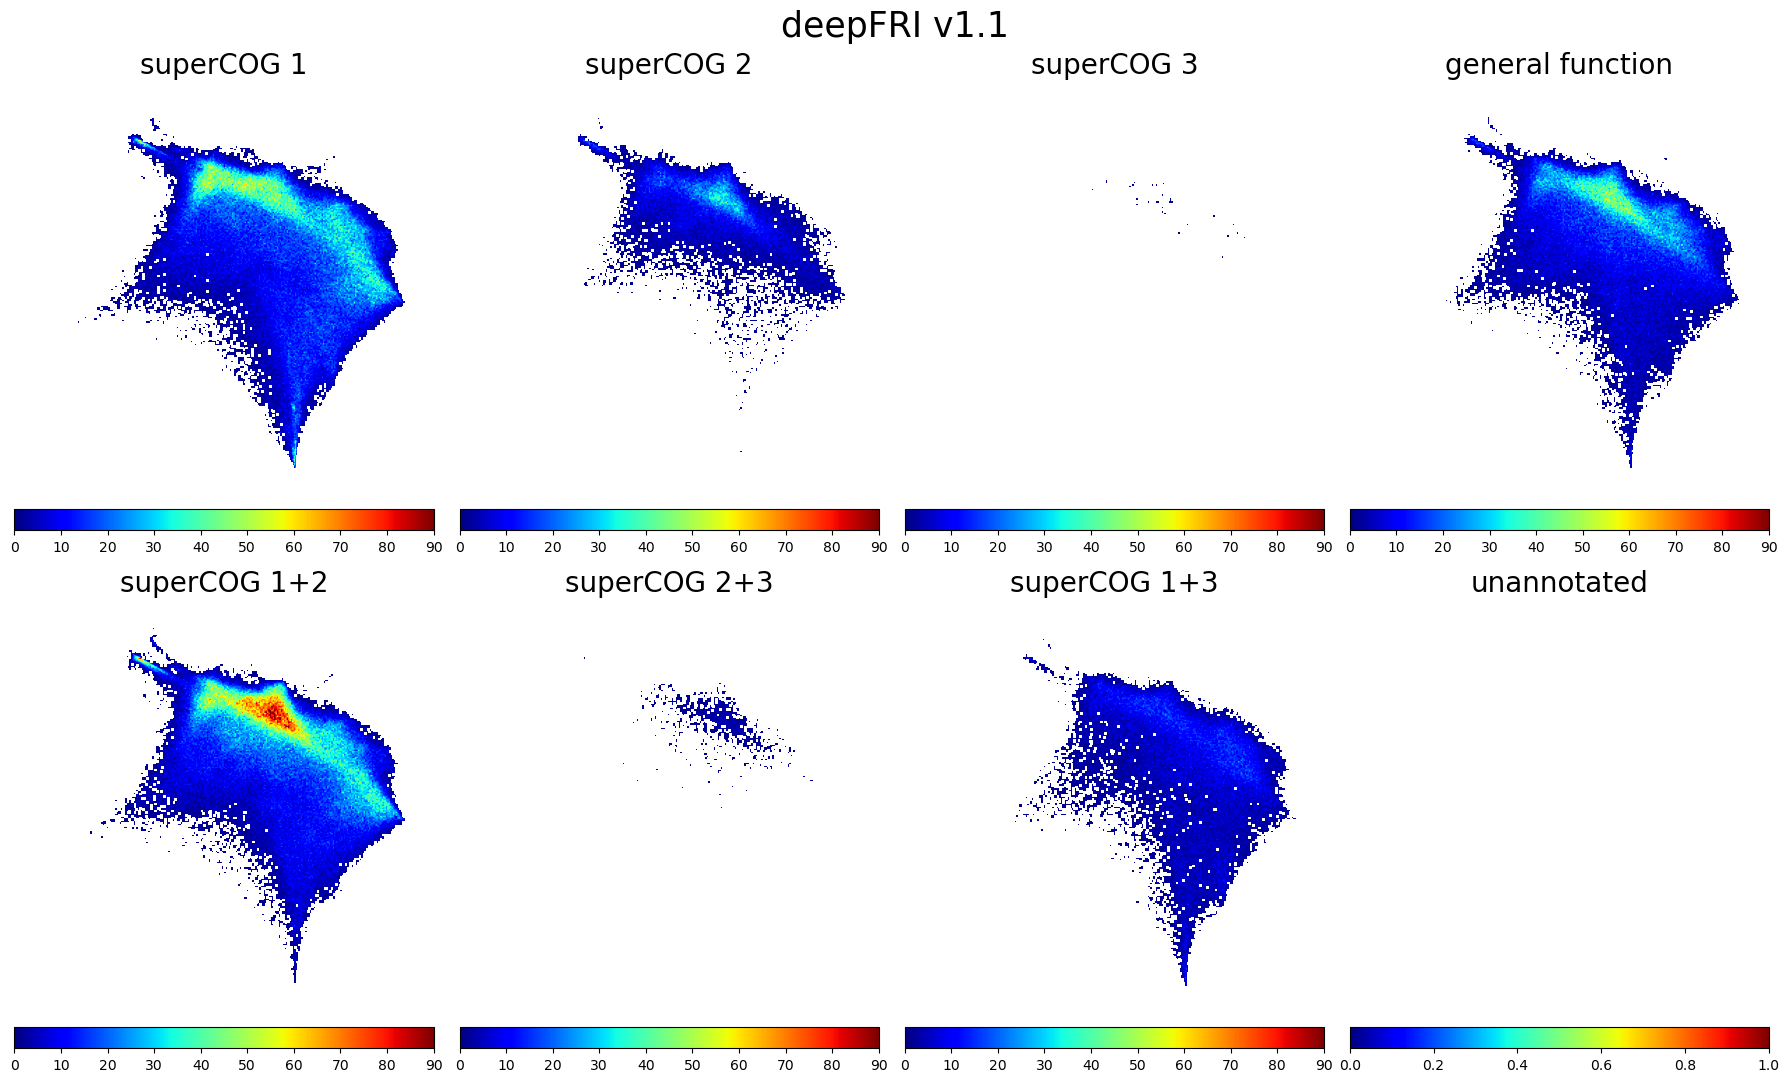

In [37]:
fig, ax = plt.subplots(2, len(super_types)//2, figsize=(18, 11))
for iter, t in enumerate(super_types):
    i = iter // (len(super_types)//2)
    j = iter % (len(super_types)//2)
    heatmap = heatmaps_s11[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i, j])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in super_types1:
        vmax = max([heatmaps_s10[t].max() for t in super_types])
    else:
        vmax = heatmaps_s11[t].max()
    im = ax[i, j].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i, j])
    ax[i, j].set_title(supercog_labels[t], fontsize=20)
    ax[i, j].set_xlim([x_min, x_max])
    ax[i, j].set_ylim([y_min, y_max])
    ax[i, j].axis('off')
plt.suptitle('deepFRI v1.1', fontsize=25)
plt.tight_layout()
plt.show()

## Fraction of structures

/tmp/ipykernel_4017428/3022680028.py:9: RuntimeWarning: invalid value encountered in divide
  im = ax[i, j].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower',


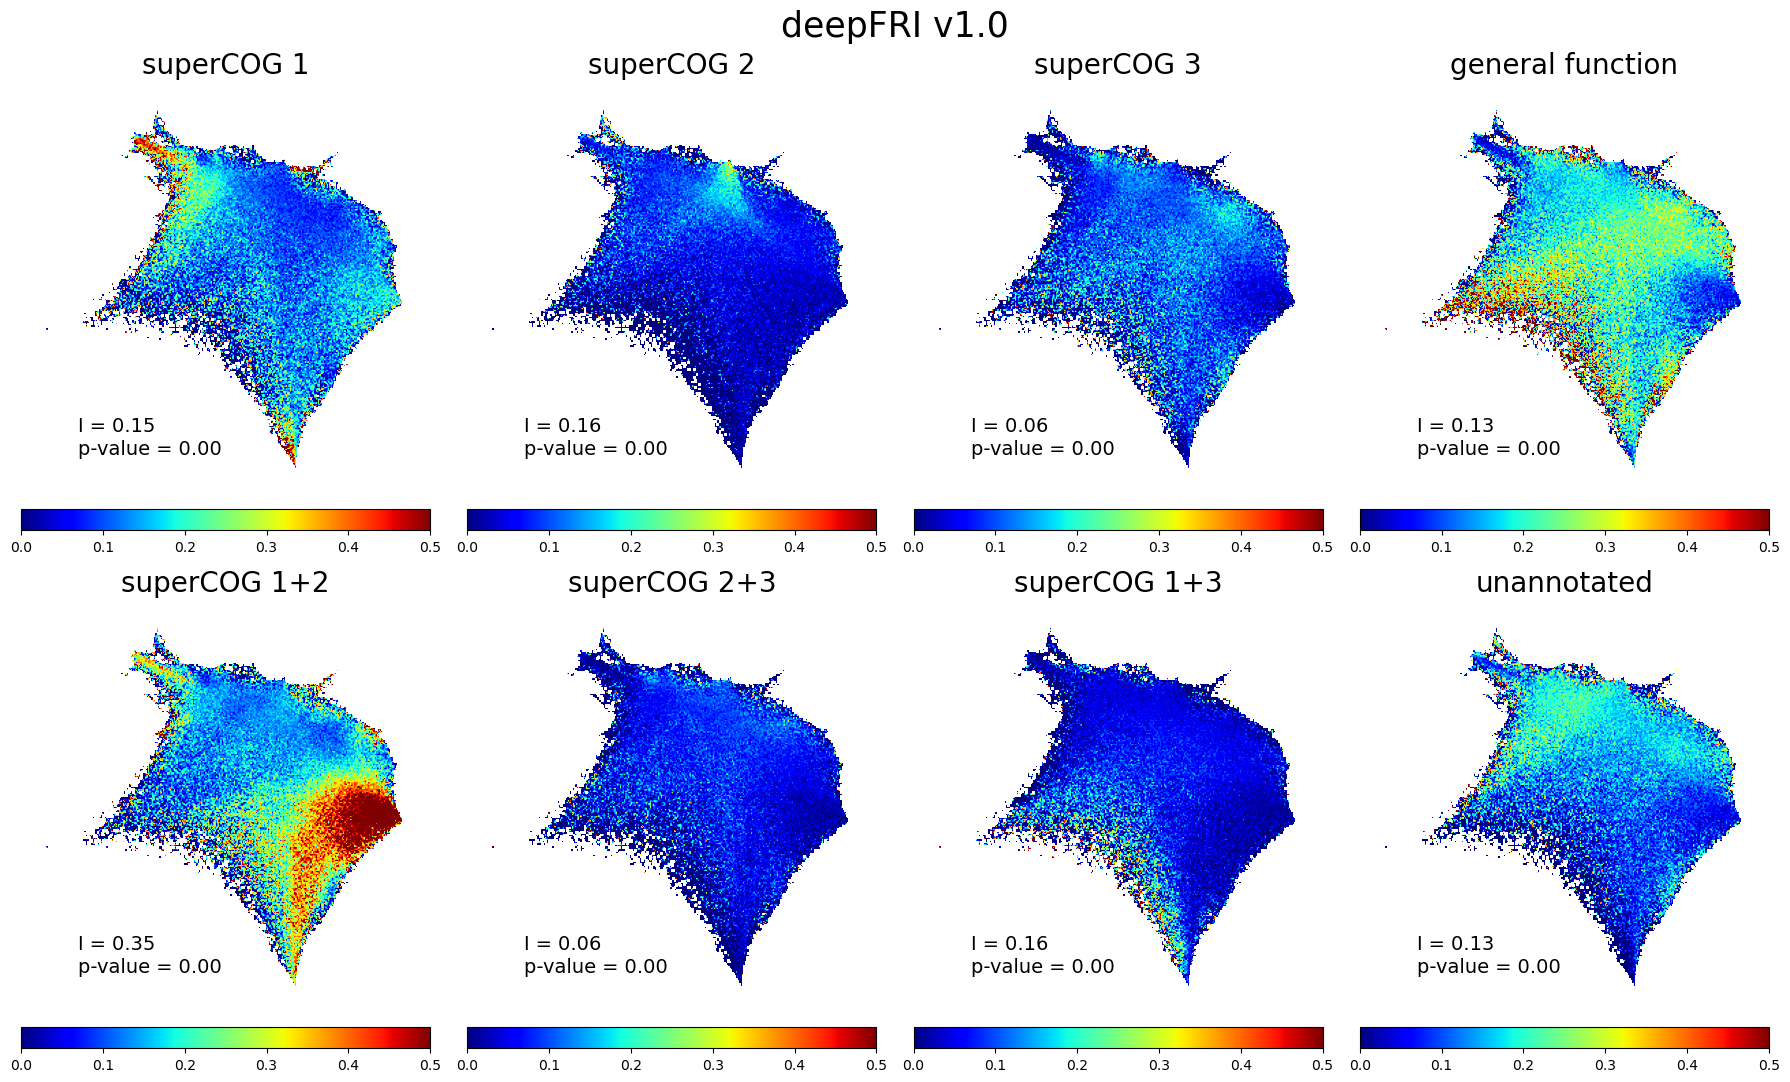

In [38]:
fig, ax = plt.subplots(2, len(super_types)//2, figsize=(18, 11))
for iter, t in enumerate(super_types):
    i = iter // (len(super_types)//2)
    j = iter % (len(super_types)//2)
    heatmap = heatmaps_s10[t]
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i, j])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    im = ax[i, j].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=.5, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i, j])
    ax[i, j].set_title(supercog_labels[t], fontsize=20)
    ax[i, j].set_xlim([x_min, x_max])
    ax[i, j].set_ylim([y_min, y_max])
    ax[i, j].axis('off')
    moran = moran_v10['I'][t]
    pvalue = moran_v10['p-value'][t]
    if type_ == 'unnormed':
        ax[i, j].text(5, -15, f"I = {moran:2.2f}", fontsize=14)
        ax[i, j].text(5, -17, f"p-value = {pvalue:.2f}", fontsize=14)
    else:
        ax[i, j].text(-12, -12, f"I = {moran:2.2f}", fontsize=14)
        ax[i, j].text(-12, -13.5, f"p-value = {pvalue:.2f}", fontsize=14)
plt.suptitle('deepFRI v1.0', fontsize=25)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4017428/3697148128.py:14: RuntimeWarning: invalid value encountered in divide
  im = ax[i, j].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower',


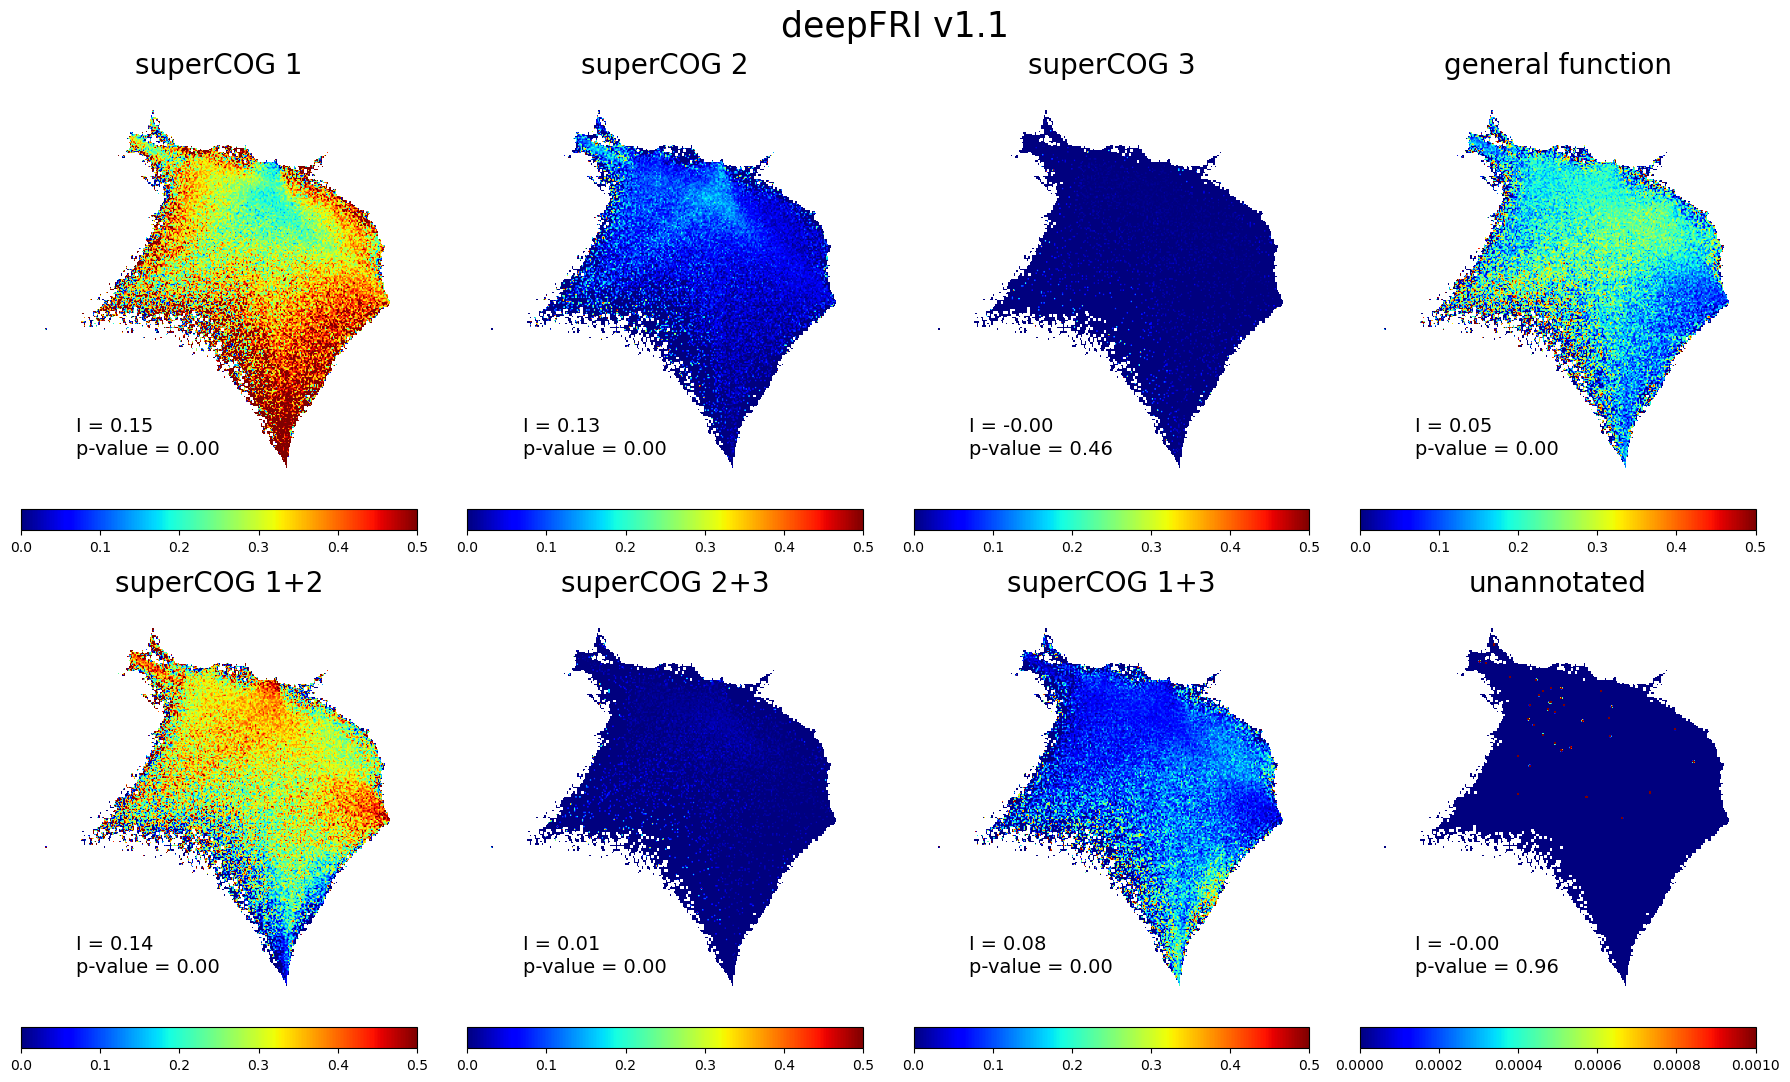

In [39]:
fig, ax = plt.subplots(2, len(super_types)//2, figsize=(18, 11))
for iter, t in enumerate(super_types):
    i = iter // (len(super_types)//2)
    j = iter % (len(super_types)//2)
    heatmap = heatmaps_s11[t]
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i, j])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if t in super_types1:
        vmax = .5
    else:
        vmax = 1e-3
    im = ax[i, j].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=vmax, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i, j])
    ax[i, j].set_title(supercog_labels[t], fontsize=20)
    ax[i, j].set_xlim([x_min, x_max])
    ax[i, j].set_ylim([y_min, y_max])
    ax[i, j].axis('off')
    moran = moran_v11['I'][t]
    pvalue = moran_v11['p-value'][t]
    if type_ == 'unnormed':
        ax[i, j].text(5, -15, f"I = {moran:2.2f}", fontsize=14)
        ax[i, j].text(5, -17, f"p-value = {pvalue:.2f}", fontsize=14)
    else:
        ax[i, j].text(-12, -12, f"I = {moran:2.2f}", fontsize=14)
        ax[i, j].text(-12, -13.5, f"p-value = {pvalue:.2f}", fontsize=14)
plt.suptitle('deepFRI v1.1', fontsize=25)
plt.tight_layout()
plt.show()

# CATH superfamilies

In [40]:
cath_classes = {
    1: 'Mainly Alpha',
    2: 'Mainly Beta',
    3: 'Alpha Beta',
    4: 'Few Sec. Str.',
    6: 'Special',
}

In [41]:
kwargs = { 'hue_order': cath_classes.values(), 'palette':"tab10",  'alpha':.5, 's':3}

/tmp/ipykernel_4017428/3794051773.py:7: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow((heatmap_cath / heatmaps_cat['is_repr']).T, extent=extent, origin='lower',


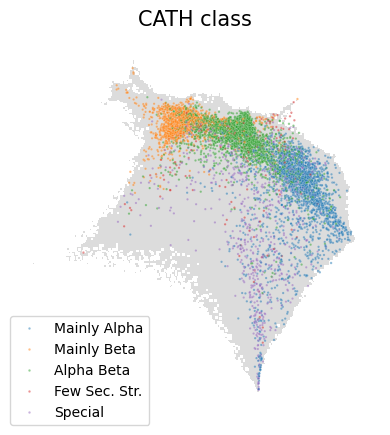

In [42]:
heatmap_cath = np.zeros((len(bins[0])-1, len(bins[1])-1))
fig, ax = plt.subplots(1, 1, figsize=(4, 4.7))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
cax = divider.append_axes('bottom', size='5%', pad=0.05)
im = ax.imshow((heatmap_cath / heatmaps_cat['is_repr']).T, extent=extent, origin='lower', 
               vmin=-.3, vmax=1, cmap=cm.Grays, aspect='auto')
if type_ == 'normed':
    g = sns.scatterplot(X_cath_pacmap_trans_normed, x='0', y='1', hue='C_map',ax=ax, **kwargs)
    ax.legend(loc=(0,0))
    
else:
    g = sns.scatterplot(X_cath_pacmap_trans_unnormed, x='0', y='1', hue='C_map',ax=ax, **kwargs)
    ax.legend(loc=(.6, 0.05))
cb = plt.colorbar(im, cax=cax, ax=ax)
cb.remove() 
ax.set_title(f'CATH class', fontsize=15)
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.axis('off')
plt.tight_layout()
plt.show()

## AFDB pLDDT

In [43]:
agg_plddt = input.groupby(['x_bin', 'y_bin'])['afdb_pLDDT'].agg(['median', 'mean', 'std', scipy.stats.median_abs_deviation]).reset_index()

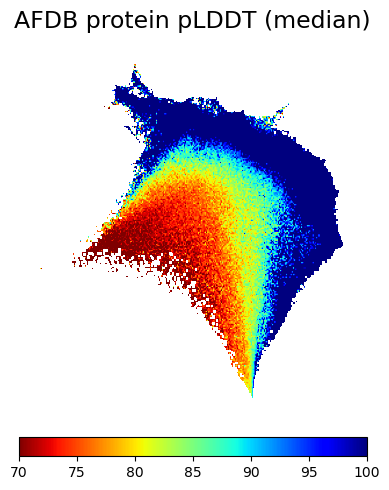

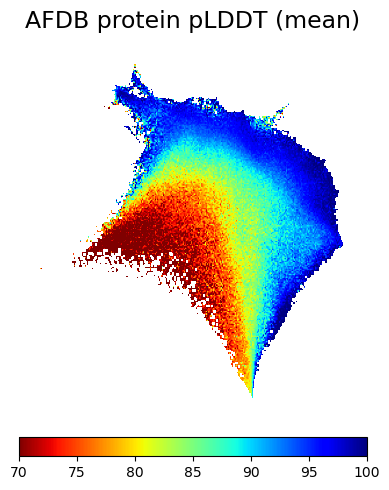

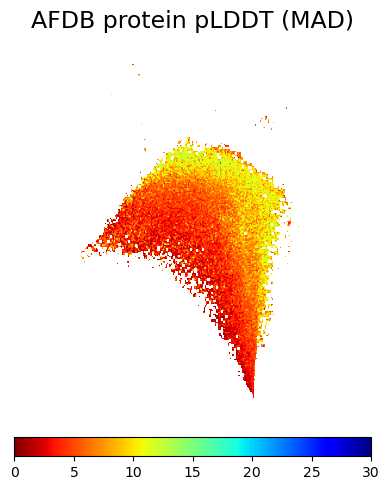

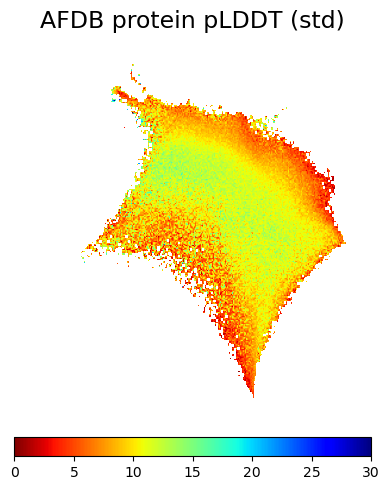

In [44]:
for feat in ['median', 'mean', 'median_abs_deviation', 'std']:
# for feat in ['median', 'median_abs_deviation']:
    heatmap_plddt = np.zeros((len(bins[0])-1, len(bins[1])-1))
    # Use np.add.at to aggregate feature values into the 3D array
    np.add.at(heatmap_plddt, (agg_plddt['x_bin'].values, 
                              agg_plddt['y_bin'].values), agg_plddt[feat].values)
    heatmap_plddt = np.where(heatmap_plddt==0, np.nan, heatmap_plddt)
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if feat in ['median', 'mean']:
        if ONLY_HQ_AFDB:
            vmin = 70; vmax = 100
        else:
            vmin = 30; vmax = 100
    else:
        vmin = 0; vmax = 30
    im = ax.imshow(heatmap_plddt.T, extent=extent, origin='lower', 
                   vmin=vmin, vmax=vmax, cmap=cm.jet_r, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax)
    if feat == 'median_abs_deviation':
        feat = 'MAD'
    ax.set_title(f'AFDB protein pLDDT ({feat})', fontsize=17)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Number of clusters

In [45]:
agg_nums = input.groupby(['x_bin', 'y_bin'])[numbers_col].agg(['median', 'mean', 'std', 
                                                               scipy.stats.median_abs_deviation]).reset_index()

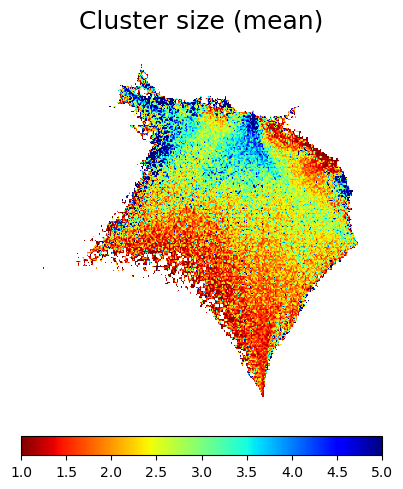

In [46]:
# for feat in ['median', 'mean', 'median_abs_deviation', 'std']:
for feat in ['mean']:
    heatmap_nums = np.zeros((len(bins[0])-1, len(bins[1])-1))
    # Use np.add.at to aggregate feature values into the 3D array
    np.add.at(heatmap_nums, (agg_nums['x_bin'].values, 
                              agg_nums['y_bin'].values), agg_nums[feat].values)
    heatmap_nums = np.where(heatmap_nums==0, np.nan, heatmap_nums)
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    if feat in ['median', 'mean']:
        vmin = 1; vmax = 5
    else:
        vmin = 0; vmax = 10
    im = ax.imshow(heatmap_nums.T, extent=extent, origin='lower', 
                   vmin=vmin, vmax=vmax, cmap=cm.jet_r, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax)
    if feat == 'median_abs_deviation':
        feat = 'MAD'
    ax.set_title(f'Cluster size ({feat})', fontsize=18)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Hetero clusters

In [47]:
heatmaps_hetero = {}
for t in ['AF-DB + hclust30', 'AF-DB + hclust30 + MIP']:
    hetero_clust[t].index = hetero_clust[t].index.str.replace('AF-', '').str.replace('-F1-model_v4', '')
    heatmaps_hetero[t], xedges, yedges = np.histogram2d(input[input.index.isin(hetero_clust[t].index)][cnames[0]],
                                                        input[input.index.isin(hetero_clust[t].index)][cnames[1]], bins=bins)

## Number of structures

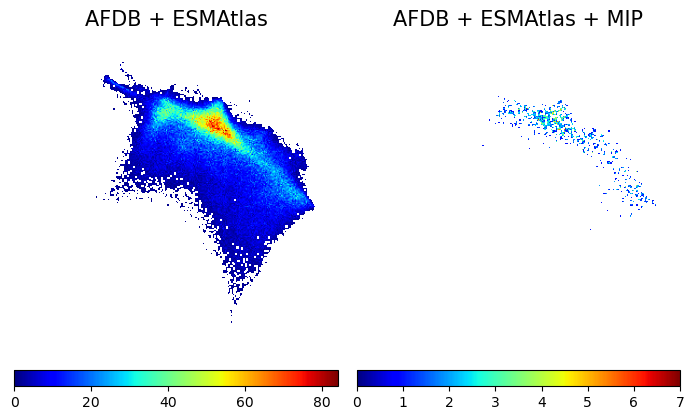

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4.3))
for i, t in enumerate(heatmaps_hetero.keys()):
    heatmap = heatmaps_hetero[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    im = ax[i].imshow(heatmap.T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    ax[i].set_title(t.replace('hclust30', 'ESMAtlas').replace('AF-DB', 'AFDB'), fontsize=15)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Fraction of structures

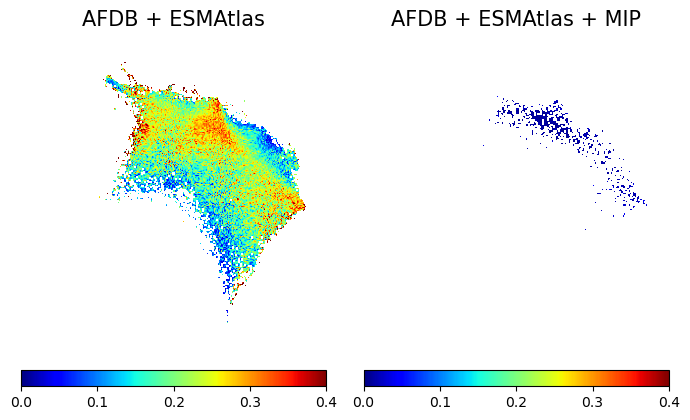

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4.3))
for i, t in enumerate(heatmaps_hetero.keys()):
    heatmap = heatmaps_hetero[t]
    heatmap = np.where(heatmap==0, np.nan, heatmap)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    im = ax[i].imshow((heatmap / heatmaps_cat['is_repr']).T, extent=extent, origin='lower', 
                      cmap=cm.jet, vmin=0, vmax=.4, aspect='auto')
    plt.colorbar(im, cax=cax, orientation="horizontal", ax=ax[i])
    ax[i].set_title(t.replace('hclust30', 'ESMAtlas').replace('AF-DB', 'AFDB'), fontsize=15)
    ax[i].set_xlim([x_min, x_max])
    ax[i].set_ylim([y_min, y_max])
    ax[i].axis('off')
plt.tight_layout()
plt.show()